## NN Adv Assignment

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Pytorch

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import warnings
warnings.filterwarnings(action='ignore')

### Load Data

In [5]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [6]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [7]:
train.shape

(59500, 785)

In [8]:
train['label'].nunique()

10

In [9]:
test.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,67,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,2,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,93,58,78,45,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,71,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,63,0,0,0,0,0,0,0


In [10]:
X = train.iloc[:, :-1].values
y = train.iloc[:, -1].values

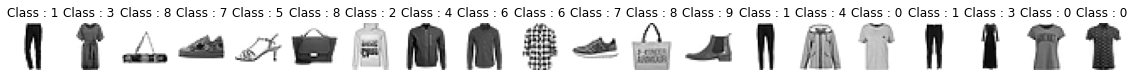

In [11]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X[idx].reshape(28, 28), cmap='gray_r')
  plt.title(f'Class : {y[idx]}')

In [12]:
X_test = test.values

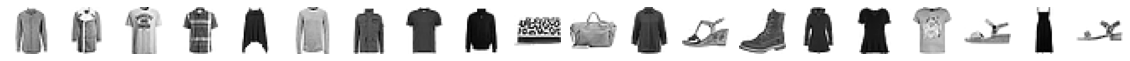

In [13]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X_test[idx].reshape(28, 28), cmap='gray_r')

### Train-Test Split

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

# Normalization
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)

In [15]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print(DEVICE)

cpu


### 데이터셋 준비

In [16]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DataSet(Dataset):
  def __init__(self, image, label = None):
    super(DataSet, self).__init__()
    self._image = image
    self._label = label

  def __len__(self):
    return len(self._image)

  def __getitem__(self, idx):
    if self._label is None:
      image = self._image[idx]
      return image

    else:
      image = self._image[idx]
      label = self._label[idx]

      return image, label

In [17]:
BATCH_SIZE = 128
EPOCHS = 15

In [18]:
# 데이터셋 준비 및 데이터 로딩 객체 선언
train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

val_dataset = DataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

test_dataset = DataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

### 모델 학습과 평가를 위한 함수 생성

In [16]:
def train(model, train_loader):
  model.train()
  train_loss = 0
  correct = 0

  for image, label in train_loader:
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(label.view_as(prediction)).sum().item()
      
  train_loss /= len(train_loader)
  train_accuracy = 100. * correct / len(train_loader.dataset)
  return train_loss, train_accuracy

In [17]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [18]:
def pred(model, test_loader):
  model.eval()
  pred_li = []

  with torch.no_grad():
    for image in test_loader:
      image = image.to(DEVICE)
      output = model(image)
      pred_li.append(output.cpu().numpy().argmax(axis=1))

  return np.concatenate(pred_li)

### DNN

#### case1 (기존)

In [19]:
BATCH_SIZE = 128
EPOCHS = 100

In [20]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.linear1 = nn.Sequential(
        nn.Linear(28 * 28, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.2)
    )
    self.linear2 = nn.Sequential(
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.2)
    )
    self.linear3 = nn.Sequential(
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.2)
    )
    self.linear4 = nn.Sequential(
        nn.Linear(128, 10)
    )

    self._init_weight_()

  def _init_weight_(self):
    for m in self.linear1:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear2:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear3:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.linear3(x)
    x = self.linear4(x)
    return x

In [21]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (linear1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (linear2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (linear3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (linear4): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [22]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 0.5330, 	Train Accuracy: 80.81 %, 	Val Loss: 0.3974, 	Val Accuracy: 85.28 % 

[EPOCH: 2], 	Train Loss: 0.4108, 	Train Accuracy: 84.99 %, 	Val Loss: 0.3892, 	Val Accuracy: 85.74 % 

[EPOCH: 3], 	Train Loss: 0.3747, 	Train Accuracy: 86.17 %, 	Val Loss: 0.3299, 	Val Accuracy: 88.07 % 

[EPOCH: 4], 	Train Loss: 0.3437, 	Train Accuracy: 87.37 %, 	Val Loss: 0.3099, 	Val Accuracy: 88.44 % 

[EPOCH: 5], 	Train Loss: 0.3275, 	Train Accuracy: 87.85 %, 	Val Loss: 0.3421, 	Val Accuracy: 87.15 % 

[EPOCH: 6], 	Train Loss: 0.3100, 	Train Accuracy: 88.68 %, 	Val Loss: 0.3158, 	Val Accuracy: 88.77 % 

[EPOCH: 7], 	Train Loss: 0.2980, 	Train Accuracy: 89.09 %, 	Val Loss: 0.3145, 	Val Accuracy: 89.05 % 

[EPOCH: 8], 	Train Loss: 0.2834, 	Train Accuracy: 89.50 %, 	Val Loss: 0.3043, 	Val Accuracy: 88.92 % 

[EPOCH: 9], 	Train Loss: 0.2753, 	Train Accuracy: 89.70 %, 	Val Loss: 0.3317, 	Val Accuracy: 87.80 % 

[EPOCH: 10], 	Train Loss: 0.2603, 	Train Accuracy: 90.31 %, 	Val Loss: 0.

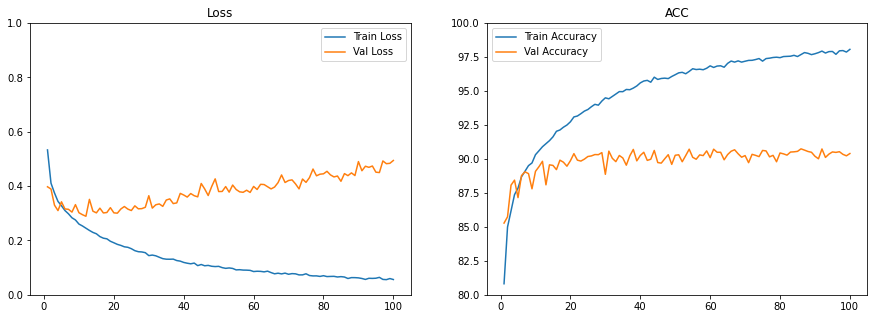

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()



#### case2

In [24]:
BATCH_SIZE = 100
EPOCHS = 250

In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            torch.nn.Linear(784, 256, bias=True),
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            torch.nn.Linear(256, 64, bias=True),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            torch.nn.Linear(64, 10, bias=True)
        )
    

    def forward(self, x):
        x = x.view(x.size(0), -1) 
        x_out = self.layer1(x)
        x_out = self.layer2(x_out)
        x_out = self.layer3(x_out)
        return x_out

def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight) 

In [26]:
model = Net().to(DEVICE)
model.apply(weights_init)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss().to(DEVICE)

print(model)

Net(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [27]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 0.8308, 	Train Accuracy: 75.08 %, 	Val Loss: 0.5466, 	Val Accuracy: 82.89 % 

[EPOCH: 2], 	Train Loss: 0.4980, 	Train Accuracy: 84.14 %, 	Val Loss: 0.4447, 	Val Accuracy: 85.60 % 

[EPOCH: 3], 	Train Loss: 0.4240, 	Train Accuracy: 85.95 %, 	Val Loss: 0.3969, 	Val Accuracy: 86.54 % 

[EPOCH: 4], 	Train Loss: 0.3816, 	Train Accuracy: 87.16 %, 	Val Loss: 0.3709, 	Val Accuracy: 87.09 % 

[EPOCH: 5], 	Train Loss: 0.3509, 	Train Accuracy: 87.97 %, 	Val Loss: 0.3514, 	Val Accuracy: 87.67 % 

[EPOCH: 6], 	Train Loss: 0.3263, 	Train Accuracy: 88.70 %, 	Val Loss: 0.3400, 	Val Accuracy: 88.06 % 

[EPOCH: 7], 	Train Loss: 0.3071, 	Train Accuracy: 89.22 %, 	Val Loss: 0.3327, 	Val Accuracy: 88.18 % 

[EPOCH: 8], 	Train Loss: 0.2910, 	Train Accuracy: 89.78 %, 	Val Loss: 0.3247, 	Val Accuracy: 88.38 % 

[EPOCH: 9], 	Train Loss: 0.2764, 	Train Accuracy: 90.36 %, 	Val Loss: 0.3161, 	Val Accuracy: 88.58 % 

[EPOCH: 10], 	Train Loss: 0.2611, 	Train Accuracy: 90.92 %, 	Val Loss: 0.

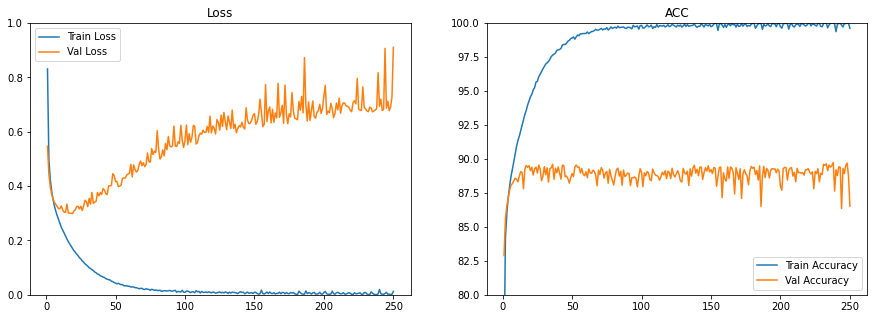

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

* BATCH SIZE와 학습률을 작게 설정한 후 EPOCH를 늘려보았으며, 가중치 초기화 함수를 다르게 적용해보았다.
* 그 결과 train accuracy 점수는 더 높아졌지만 기존의 DNN보다 val accuracy가 낮아졌기 때문에 성능이 좋아졌다고 판단하기는 어렵다.

## CNN

* DNN이 아닌 CNN을 사용했을 때의 학습결과도 비교해보기 위해 모델을 구성해보았다.

In [19]:
def train(model, train_loader):
  model.train()
  train_loss = 0
  correct = 0

  for image, label in train_loader:
    image = image.view(-1,1,28,28).to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(label.view_as(prediction)).sum().item()
      
  train_loss /= len(train_loader)
  train_accuracy = 100. * correct / len(train_loader.dataset)
  return train_loss, train_accuracy

In [20]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.view(-1,1,28,28).to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

* CNN은 DNN과 달리 이미지의 원본이 모델의 input으로 들어가기 때문에 살짝 변경해주었다.

### case3

In [21]:
BATCH_SIZE = 100
EPOCHS = 10

In [22]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [23]:
model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [24]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 0.4742, 	Train Accuracy: 83.11 %, 	Val Loss: 0.3250, 	Val Accuracy: 88.68 % 

[EPOCH: 2], 	Train Loss: 0.3180, 	Train Accuracy: 88.61 %, 	Val Loss: 0.2900, 	Val Accuracy: 89.75 % 

[EPOCH: 3], 	Train Loss: 0.2778, 	Train Accuracy: 89.98 %, 	Val Loss: 0.2721, 	Val Accuracy: 89.98 % 

[EPOCH: 4], 	Train Loss: 0.2455, 	Train Accuracy: 91.04 %, 	Val Loss: 0.2692, 	Val Accuracy: 90.22 % 

[EPOCH: 5], 	Train Loss: 0.2313, 	Train Accuracy: 91.60 %, 	Val Loss: 0.2870, 	Val Accuracy: 89.61 % 

[EPOCH: 6], 	Train Loss: 0.2120, 	Train Accuracy: 92.22 %, 	Val Loss: 0.2364, 	Val Accuracy: 91.64 % 

[EPOCH: 7], 	Train Loss: 0.1956, 	Train Accuracy: 92.86 %, 	Val Loss: 0.2454, 	Val Accuracy: 91.55 % 

[EPOCH: 8], 	Train Loss: 0.1816, 	Train Accuracy: 93.39 %, 	Val Loss: 0.2598, 	Val Accuracy: 91.40 % 

[EPOCH: 9], 	Train Loss: 0.1754, 	Train Accuracy: 93.57 %, 	Val Loss: 0.2469, 	Val Accuracy: 91.43 % 

[EPOCH: 10], 	Train Loss: 0.1604, 	Train Accuracy: 94.22 %, 	Val Loss: 0.

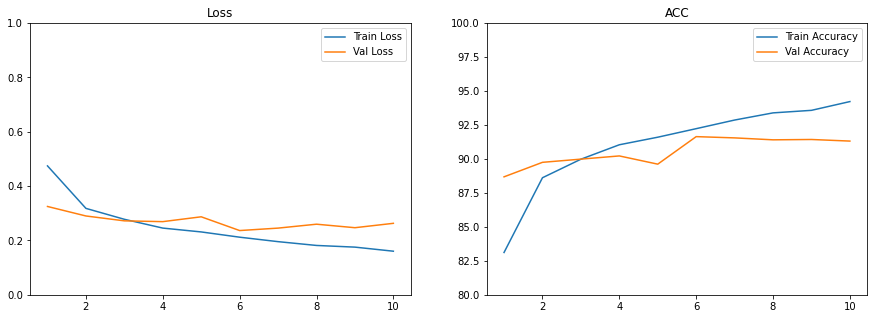

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

* CNN을 통해 학습을 진행해본 결과 기존의 베이스라인보다 accuracy가 높아진 것이 확인되었으며, 성능이 좋아졌다고 판단되었다.